In [1]:
#-------------------------------------------------------------
#--- V net with patches
#-------------------------------------------------------------

# Pass

In [2]:
#-------------------------------------------------------------
#--- ALL IMPORTS
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- IMPORTING ESSENTIALS")
print("#-------------------------------------------------------------\n")

try:
    import monai
    import torch
    import itk
    import numpy as np
    import matplotlib.pyplot as plt
    import random
    import glob
    import os.path
    import tempfile
    from monai.transforms import LoadImage
    from monai.metrics import DiceMetric
    from torch.nn.functional import one_hot

    from utils import (
        preview_image,
        preview_3D_vector_field,
        preview_3D_deformation,
        jacobian_determinant,
        plot_against_epoch_numbers,
    )

except ImportError as e:
    print("Importing error:",e)

#-------------------------------------------------------------
#--- IMPORTING ESSENTIALS
#-------------------------------------------------------------



In [3]:
#-------------------------------------------------------------
#--- ASSIGNING DEVICE
#-------------------------------------------------------------

def get_device():
    print("#-------------------------------------------------------------")
    print("#--- ASSIGNING DEVICE")
    print("#-------------------------------------------------------------\n")

    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        print("CUDA is available.")
        print("GPU:", torch.cuda.get_device_name(0)) # Prints the GPU name
    else:
        device = torch.device("cpu")
        print("CUDA not available. Using CPU.")
    print("Using device:", device)
    return device

# Implementation of the above function
device = get_device()

#-------------------------------------------------------------
#--- ASSIGNING DEVICE
#-------------------------------------------------------------

CUDA is available.
GPU: NVIDIA GeForce RTX 3070 Laptop GPU
Using device: cuda:0


In [4]:
#-------------------------------------------------------------
#--- CHECKING MONAI CONFIGURATION
#-------------------------------------------------------------

def configure_environment(seed=77):
    print("#-------------------------------------------------------------")
    print("#--- CHECKING MONAI CONFIGURATION")
    print("#-------------------------------------------------------------\n")

    # Set reproducibility
    monai.utils.set_determinism(seed=seed)
    print(f"Deterministic seed set to {seed}")

    # Disable ITK warnings
    itk.ProcessObject.SetGlobalWarningDisplay(False)
    # Disable TF32 for consistency
    torch.backends.cuda.matmul.allow_tf32 = False
    torch.backends.cudnn.allow_tf32 = False

    # Print MONAI config
    monai.config.print_config()

    # Enable inline plotting if in Jupyter
    try:
        get_ipython()
        from IPython import get_ipython
        get_ipython().run_line_magic("matplotlib", "inline")
        print("Notebook detected: Enabled %matplotlib inline")
    except Exception:
        pass

# Implementation of above function
configure_environment()

#-------------------------------------------------------------
#--- CHECKING MONAI CONFIGURATION
#-------------------------------------------------------------

Deterministic seed set to 77
MONAI version: 1.5.0
Numpy version: 2.1.2
Pytorch version: 2.5.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: d388d1c6fec8cb3a0eebee5b5a0b9776ca59ca83
MONAI __file__: c:\Users\<username>\OneDrive\Desktop\Choreko\hmpt\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.4.4
Nibabel version: 5.3.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 11.0.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.20.1+cu121
tqdm version: NOT INSTALLED or UNKNOWN VERSION.
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.0.0


In [ ]:
#-------------------------------------------------------------
#--- ASSIGNING PATHS
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- ASSIGNING PATHS")
print("#-------------------------------------------------------------\n")

directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)

root_dir = r"C:\Users\Praful\OneDrive\Desktop\Choreko\OASIS_root" # This should be in the same folder as env
os.makedirs(root_dir, exist_ok=True)  
print(f"Root directory: {root_dir}")

segmentation_path_expression = "IBSR_Mask/IBSR_*_segTRI_fill_ana.nii"
image_paths = glob.glob(r"C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_*_ana_strip.nii")
segmentation_paths = glob.glob(r"C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Mask\IBSR_*_segTRI_fill_ana.nii")

print(image_paths)
print(len(image_paths),"\n")

print(segmentation_paths)
print(len(segmentation_paths),"\n")

#-------------------------------------------------------------
#--- ASSIGNING PATHS
#-------------------------------------------------------------

Root directory: C:\Users\Praful\OneDrive\Desktop\Choreko\OASIS_root
['C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_01_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_02_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_03_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_04_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_05_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_06_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_07_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_08_ana_str

In [6]:
#-------------------------------------------------------------
#--- RESIZING AND ASSUMING FIX NUMBER OF SEGMENTS
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- RESIZING AND ASSUMING FIX NUMBER OF SEGMENTS")
print("#-------------------------------------------------------------\n")

resize = 128
num_segmentation_classes = 4  # background, CSF, white matter, gray matter
# Pretend that only a few segmentations are available
num_segs_to_select = 18
np.random.shuffle(segmentation_paths)
segmentation_paths = segmentation_paths[:num_segs_to_select]
print(segmentation_paths)
print(len(segmentation_paths),"\n")

#-------------------------------------------------------------
#--- RESIZING AND ASSUMING FIX NUMBER OF SEGMENTS
#-------------------------------------------------------------

['C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_14_segTRI_fill_ana.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_18_segTRI_fill_ana.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_02_segTRI_fill_ana.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_11_segTRI_fill_ana.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_03_segTRI_fill_ana.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_13_segTRI_fill_ana.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_16_segTRI_fill_ana.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR

In [10]:
#-------------------------------------------------------------
#--- EXTRACTING IDs
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- EXTRACTING IDs HAVING BOTH IMG AND SEG")
print("#-------------------------------------------------------------\n")

# Function to extract the image ID from the file path
def path_to_id(path):
    return "_".join(os.path.basename(path).split("_")[:2])

seg_ids = list(map(path_to_id, segmentation_paths))
print(seg_ids,"\n")

# Creates a lazy map object, meaning it holds the instructions to apply path_to_id() but hasn’t executed them yet.
img_ids = map(path_to_id, image_paths)
print(img_ids,"\n")     # This just prints the object’s memory address, not the content:

# TO SEE THE ACTUAL IDs UNCOMMENT THIS
'''
img_ids = list(map(path_to_id, image_paths))
print(img_ids)
'''

#-------------------------------------------------------------
#--- EXTRACTING IDs HAVING BOTH IMG AND SEG
#-------------------------------------------------------------

['IBSR_14', 'IBSR_18', 'IBSR_02', 'IBSR_11', 'IBSR_03', 'IBSR_13', 'IBSR_16', 'IBSR_05', 'IBSR_07', 'IBSR_15', 'IBSR_04', 'IBSR_17', 'IBSR_08', 'IBSR_10', 'IBSR_01', 'IBSR_09', 'IBSR_06', 'IBSR_12'] 




'\nimg_ids = list(map(path_to_id, image_paths))\nprint(img_ids)\n'

In [11]:
#-------------------------------------------------------------
#--- CHOOSING THE SPLIT
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- CHOOSING THE SPLIT")
print("#-------------------------------------------------------------\n")

data = []
for img_index, img_id in enumerate(img_ids):
    data_item = {"img": image_paths[img_index]} # Create a dictionary with the image file path
    if img_id in seg_ids: # Check if this image has a corresponding segmentation file
        data_item["seg"] = segmentation_paths[seg_ids.index(img_id)] # Add segmentation file path to the dictionary
    data.append(data_item) # Add this dictionary to the data list

print(data)
print(len(data),"\n")

# Filters data to keep only entries that contain a segmentation path.
data_seg_available = list(filter(lambda d: "seg" in d.keys(), data))

# Filters data to keep entries that only have an image (no "seg" key).
data_seg_unavailable = list(filter(lambda d: "seg" not in d.keys(), data))

# Splits data_seg_available into:
# 80% for training
# 20% for validation
data_seg_available_train, data_seg_available_valid = monai.data.utils.partition_dataset(
    data_seg_available, ratios=(8, 2) # 80/20
)
# Validation of the segmentation network only makes sense if you have enough segmentation labels.
# E.g. definitely skip validation here if there's just one segmentation label.

print(f"Number of data items with segmentation labels: {len(data_seg_available)}")
print(f"Number of data items with segmentation labels for training: {len(data_seg_available_train)}")
print(f"Number of data items with segmentation labels for validation: {len(data_seg_available_valid)}")
print(f"Number of data items without segmentation labels: {len(data_seg_unavailable)}")

print(data_seg_available_train)
print(data_seg_available_valid)
print(data_seg_unavailable)

#-------------------------------------------------------------
#--- CHOOSING THE SPLIT
#-------------------------------------------------------------

[{'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_01_ana_strip.nii', 'seg': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_01_segTRI_fill_ana.nii'}, {'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_02_ana_strip.nii', 'seg': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_02_segTRI_fill_ana.nii'}, {'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_03_ana_strip.nii', 'seg': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_03_segTRI_fill_ana.nii'}, {'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_04_ana_strip.nii', 'seg': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_M

In [12]:
#-------------------------------------------------------------
#--- STUDING DATA
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- STUDYING DATA")
print("#-------------------------------------------------------------\n")

! pip install nibabel
from monai.transforms import LoadImage
import torch

# Initialize the loader
loader = LoadImage(image_only=True)

# Loop over each item in your data list
for idx, item in enumerate(data):
    print(f"\nData index: {idx}")

    # Load and print the shape of the image
    img_tensor = loader(item["img"])
    print(f"Image path: {item['img']}")
    print(f"Image shape (torch tensor): {img_tensor.shape}")

    # Load and print the shape of the segmentation if it exists
    if "seg" in item:
        seg_tensor = loader(item["seg"])
        print(f"Segmentation path: {item['seg']}")
        print(f"Segmentation shape (torch tensor): {seg_tensor.shape}")



#-------------------------------------------------------------
#--- STUDYING DATA
#-------------------------------------------------------------


Data index: 0
Image path: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_01_ana_strip.nii
Image shape (torch tensor): torch.Size([256, 128, 256])



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Segmentation path: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Mask\IBSR_01_segTRI_fill_ana.nii
Segmentation shape (torch tensor): torch.Size([256, 128, 256, 1])

Data index: 1
Image path: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_02_ana_strip.nii
Image shape (torch tensor): torch.Size([256, 128, 256])
Segmentation path: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Mask\IBSR_02_segTRI_fill_ana.nii
Segmentation shape (torch tensor): torch.Size([256, 128, 256, 1])

Data index: 2
Image path: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_03_ana_strip.nii
Image shape (torch tensor): torch.Size([256, 128, 256])
Segmentation path: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Mask\IBSR_03_segTRI_fill_ana.nii
Segmentation shape (torch tensor): torch.Size([256, 128, 256, 1])

Data index: 3
Image path: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_04_ana_strip.nii
Ima


#-------------------------------------------------------------
#--- VISUALIZING DATA
#-------------------------------------------------------------



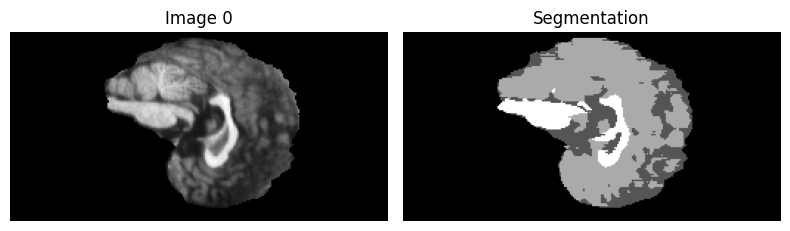

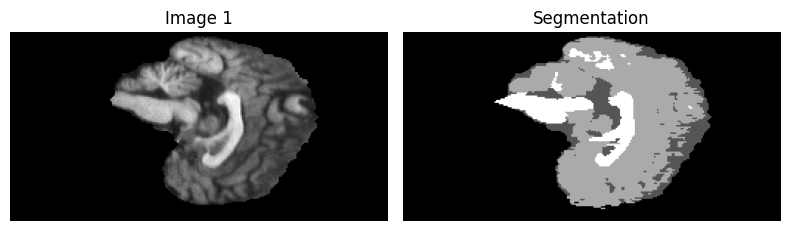

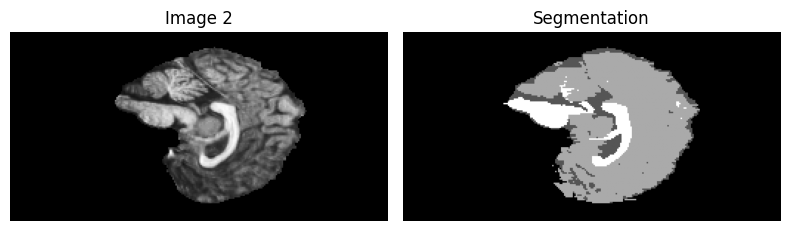

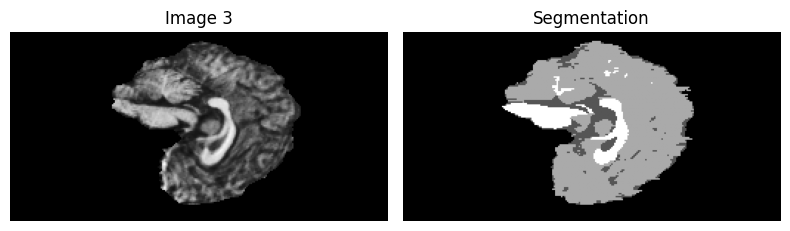

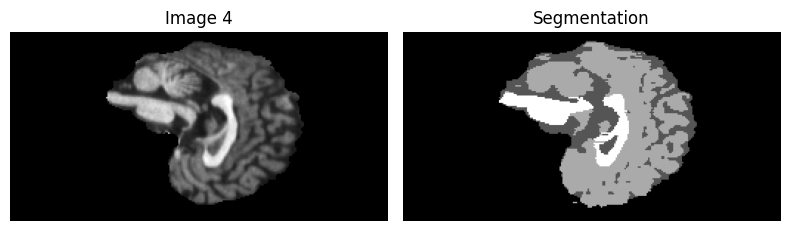

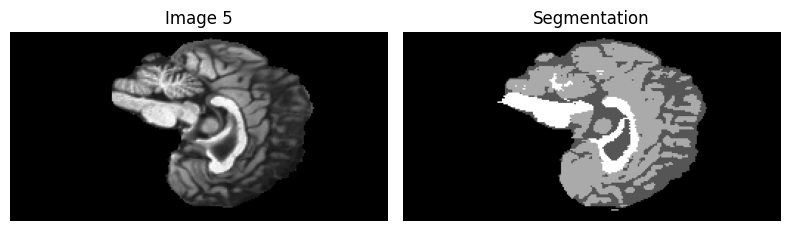

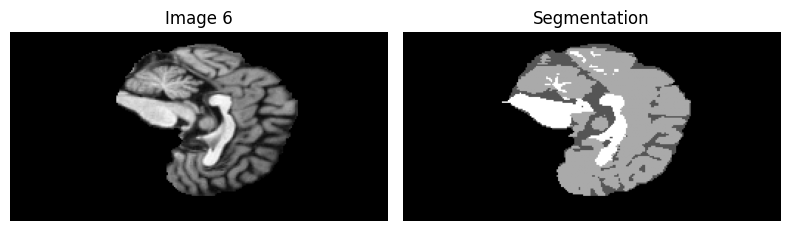

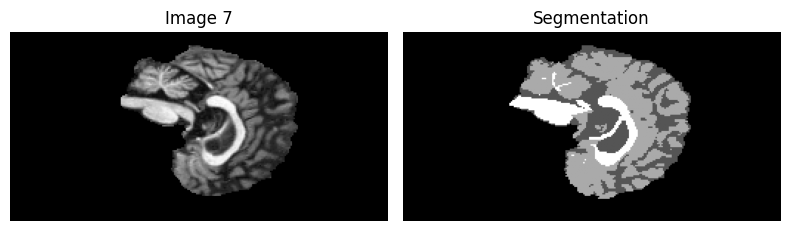

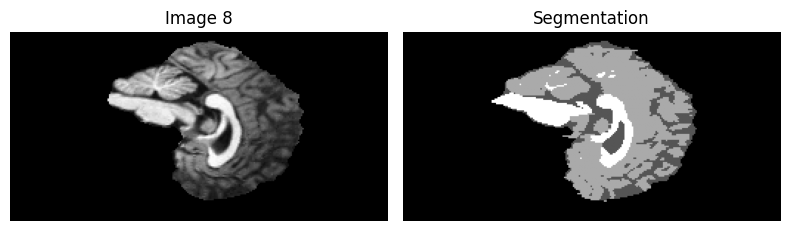

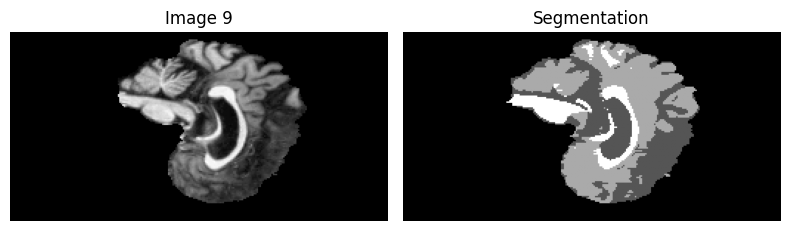

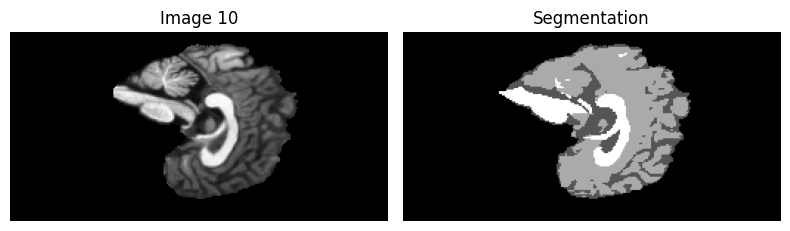

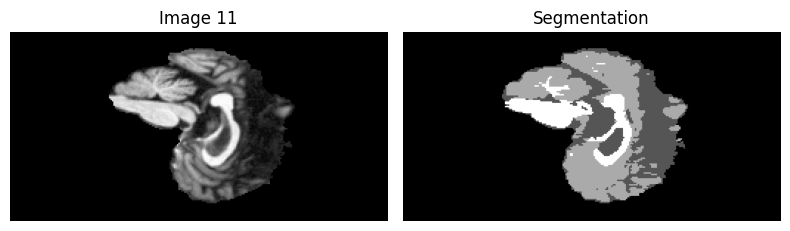

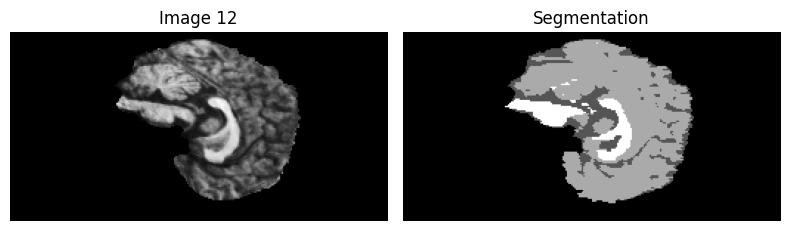

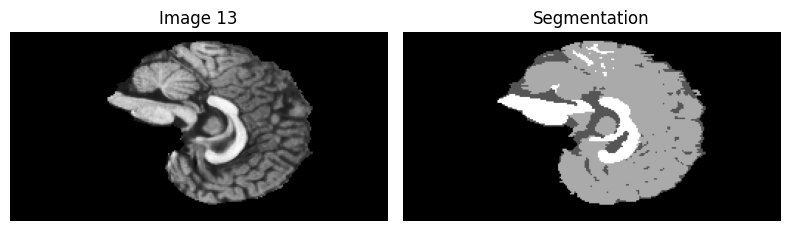

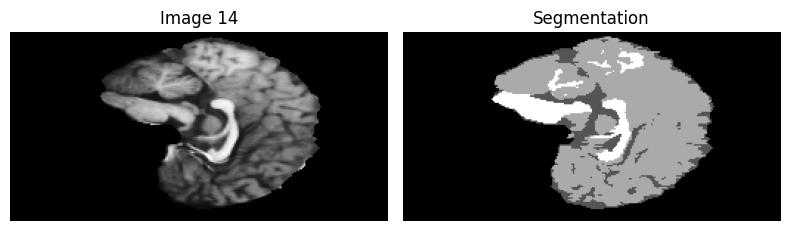

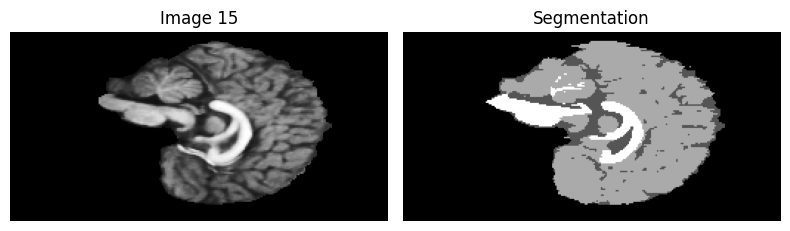

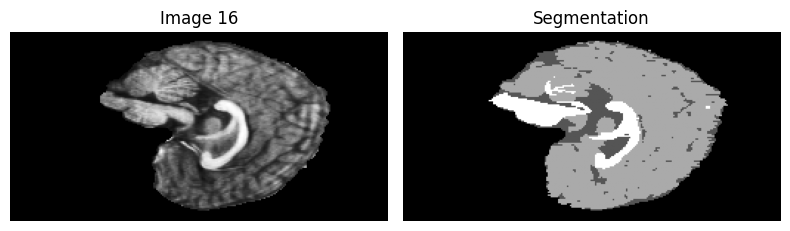

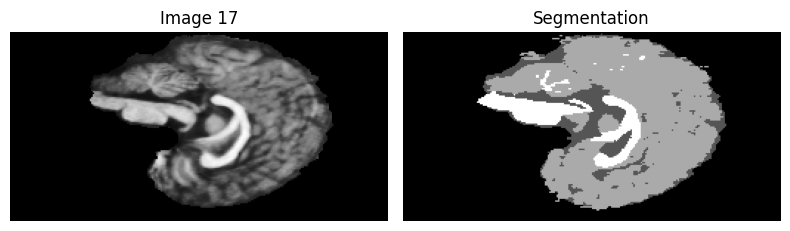

In [13]:
#-------------------------------------------------------------
#--- VISUALIZING DATA
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- VISUALIZING DATA")
print("#-------------------------------------------------------------\n")

import matplotlib.pyplot as plt
from monai.transforms import LoadImage

# Loader to convert filepath to array
loader = LoadImage(image_only=True)

for i, item in enumerate(data):
    img = loader(item["img"])
    
    has_seg = "seg" in item
    fig, axs = plt.subplots(1, 2 if has_seg else 1, figsize=(8, 4))
    
    # Ensure axs is always a list for uniform access
    if not has_seg:
        axs = [axs]
    
    # Display the image (middle slice)
    axs[0].imshow(img[img.shape[0] // 2], cmap='gray')
    axs[0].set_title(f"Image {i}")
    axs[0].axis('off')

    # If segmentation exists, display it too
    if has_seg:
        seg = loader(item["seg"])
        axs[1].imshow(seg[seg.shape[0] // 2], cmap='gray')
        axs[1].set_title("Segmentation")
        axs[1].axis('off')

    plt.tight_layout()
    plt.show()



#-------------------------------------------------------------
#--- DISPLAYING RANDOM IMAGE
#-------------------------------------------------------------



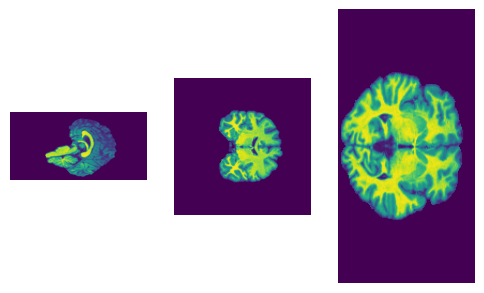

In [14]:
#-------------------------------------------------------------
#--- DISPLAYING RANDOM IMAGE
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- DISPLAYING RANDOM IMAGE")
print("#-------------------------------------------------------------\n")

data_item = random.choice(data)
preview_image(monai.transforms.LoadImage(image_only=True)(data_item['img']), figsize=(6,6), normalize_by="slice")

In [16]:
#-------------------------------------------------------------
#--- APPLYING PREPROCESSING TRANSFORMATION
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- APPLYING PREPROCESSING TRANSFORMATION")
print("#-------------------------------------------------------------\n")

# Define patch size and number of samples
patch_size = (32, 32, 32)
num_samples = 4

# set of preprocessing transformations
transform_seg_available_t = monai.transforms.Compose(
    transforms = [
        monai.transforms.LoadImageD(keys=["img", "seg"], image_only=True),
        monai.transforms.EnsureChannelFirstD(keys=["img", "seg"]),
        monai.transforms.EnsureTypeD(keys=["img", "seg"]),
        monai.transforms.TransposeD(keys=["img", "seg"], indices=(0,1,2,3)),
        (
            monai.transforms.ResizeD(
                keys=["img", "seg"],
                spatial_size=(resize, resize, resize),
                mode=["trilinear", "nearest"],
                align_corners=[False, None],
            )
            if resize is not None
            else monai.transforms.Identity()
        ),
        # Foreground-aware 3D patch extraction
        monai.transforms.RandCropByPosNegLabeld(
            keys=["img", "seg"],
            label_key="seg",
            spatial_size=patch_size,
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="img",
        ),
    ]
)

# set of preprocessing transformations
transform_seg_available_v = monai.transforms.Compose(
    transforms = [
        monai.transforms.LoadImageD(keys=["img", "seg"], image_only=True),
        monai.transforms.EnsureChannelFirstD(keys=["img", "seg"]),
        monai.transforms.EnsureTypeD(keys=["img", "seg"]),
        monai.transforms.TransposeD(keys=["img", "seg"], indices=(0,1,2,3)),
        (
            monai.transforms.ResizeD(
                keys=["img", "seg"],
                spatial_size=(resize, resize, resize),
                mode=["trilinear", "nearest"],
                align_corners=[False, None],
            )
            if resize is not None
            else monai.transforms.Identity()
        ),
    ]
)

print(resize)

dataset_seg_available_train = monai.data.CacheDataset(
    data=data_seg_available_train, transform=transform_seg_available_t, cache_num=4 # 16
)

dataset_seg_available_valid = monai.data.CacheDataset(
    data=data_seg_available_valid, transform=transform_seg_available_v, cache_num=4 # 16
)


#-------------------------------------------------------------
#--- APPLYING PREPROCESSING TRANSFORMATION
#-------------------------------------------------------------

128



#-------------------------------------------------------------
#--- PREVIEW RANDOM IMAGE
#-------------------------------------------------------------



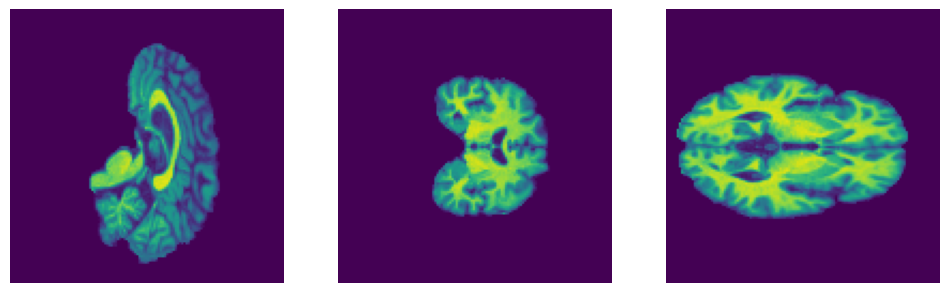

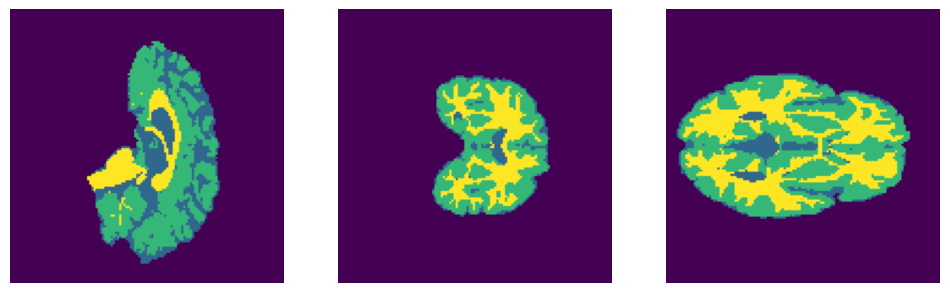

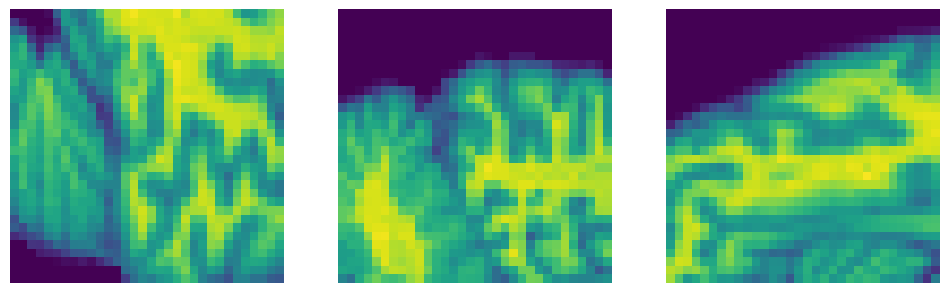

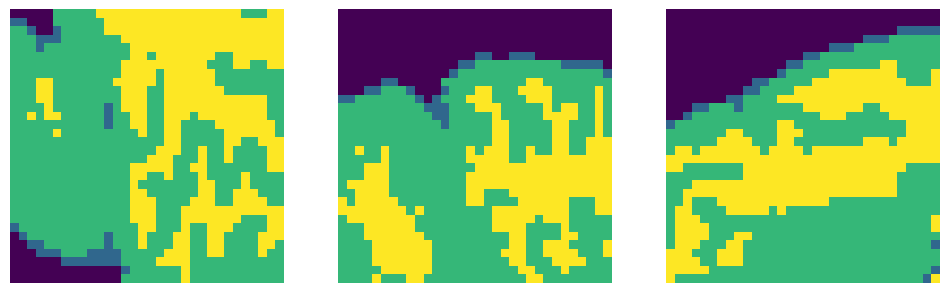

In [18]:
#-------------------------------------------------------------
#--- PREVIEW RANDOM IMAGE
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- PREVIEW RANDOM IMAGE")
print("#-------------------------------------------------------------\n")


data_item = transform_seg_available_v(random.choice(data_seg_available))

preview_image(data_item['img'][0])
preview_image(data_item['seg'][0])

# THIS IS FOR TRAIN USING PATCH BASED

data_item_list = transform_seg_available_t(random.choice(data_seg_available))  
# data_item_list is a list of dicts, each dict has 'img' and 'seg'

# Pick the first patch dict
patch0 = data_item_list[0]

# patch0 is a dict, so now you can access 'img' and 'seg'
img_patch = patch0['img']  # tensor shape: (1, 96, 96, 96)
seg_patch = patch0['seg']

# remove channel dim
img_patch = img_patch[0]  # shape: (96, 96, 96)
seg_patch = seg_patch[0]

# pick middle slice
z = img_patch.shape[0] // 2

# preview slice
preview_image(img_patch)
preview_image(seg_patch)


In [19]:
#-------------------------------------------------------------
#--- CHECKING THE SHAPE OF LOADED SEG MASK
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- CHECKING THE SHAPE OF LOADED SEG MASK")
print("#-------------------------------------------------------------\n")

from monai.transforms import LoadImage

# Set up the loader
loader = LoadImage(image_only=True)

# Print the shape of all loaded segmentation masks
def print_all_seg_shapes(data):
    for i, data_item in enumerate(data):
        if "seg" in data_item:
            seg_tensor = loader(data_item["seg"])  # load from path
            print(f"Item {i}: seg shape = {seg_tensor.shape}")
        else:
            print(f"Item {i}: seg key not found")

# Run it
print_all_seg_shapes(data_seg_available_train)
print("-----------------------------------------------")
print_all_seg_shapes(data_seg_available_valid)


#-------------------------------------------------------------
#--- CHECKING THE SHAPE OF LOADED SEG MASK
#-------------------------------------------------------------

Item 0: seg shape = torch.Size([256, 128, 256, 1])
Item 1: seg shape = torch.Size([256, 128, 256, 1])
Item 2: seg shape = torch.Size([256, 128, 256, 1])
Item 3: seg shape = torch.Size([256, 128, 256, 1])
Item 4: seg shape = torch.Size([256, 128, 256, 1])
Item 5: seg shape = torch.Size([256, 128, 256, 1])
Item 6: seg shape = torch.Size([256, 128, 256, 1])
Item 7: seg shape = torch.Size([256, 128, 256, 1])
Item 8: seg shape = torch.Size([256, 128, 256, 1])
Item 9: seg shape = torch.Size([256, 128, 256, 1])
Item 10: seg shape = torch.Size([256, 128, 256, 1])
Item 11: seg shape = torch.Size([256, 128, 256, 1])
Item 12: seg shape = torch.Size([256, 128, 256, 1])
Item 13: seg shape = torch.Size([256, 128, 256, 1])
-----------------------------------------------
Item 0: seg shape = torch.Size([256, 128, 256, 1])
Item 1: seg 

In [ ]:
#-------------------------------------------------------------
#--- DEFINING SEG NET
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- DEFINING SEG NET")
print("#-------------------------------------------------------------\n")

from monai.networks.nets import VNet

seg_net = VNet(
    spatial_dims=3, 
    in_channels=1, 
    out_channels=4, 
    act=('leakyrelu', {'negative_slope': 0.01, 'inplace': True}), 
    dropout_prob=0, 
    dropout_prob_down=0.3, 
    dropout_prob_up=(0.0, 0.3), 
    dropout_dim=3, 
    bias=False
)


#-------------------------------------------------------------
#--- DEFINING SEG NET
#-------------------------------------------------------------



monai.networks.nets.vnet VNet.__init__:dropout_prob: Argument `dropout_prob` has been deprecated since version 1.2. please use `dropout_prob_down` instead.
monai.networks.nets.vnet VNet.__init__:dropout_prob: Argument `dropout_prob` has been deprecated since version 1.2. please use `dropout_prob_up` instead.


In [21]:
! pip install torchinfo

from torchinfo import summary
import torch

# Assuming your model is named seg_net and input shape is (batch_size, channels, D, H, W)
input_size = (1, 1, 96, 96, 96)  # example input shape, adjust patch size as per your data

summary(seg_net, input_size=input_size, device="cpu")  # or "cuda" if model on GPU


  Obtaining dependency information for torchinfo from https://files.pythonhosted.org/packages/72/25/973bd6128381951b23cdcd8a9870c6dcfc5606cb864df8eabd82e529f9c1/torchinfo-1.8.0-py3-none-any.whl.metadata



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Layer (type:depth-idx)                             Output Shape              Param #
VNet                                               [1, 4, 96, 96, 96]        --
├─InputTransition: 1-1                             [1, 16, 96, 96, 96]       --
│    └─Convolution: 2-1                            [1, 16, 96, 96, 96]       --
│    │    └─Conv3d: 3-1                            [1, 16, 96, 96, 96]       2,000
│    │    └─ADN: 3-2                               [1, 16, 96, 96, 96]       32
│    └─LeakyReLU: 2-2                              [1, 16, 96, 96, 96]       --
├─DownTransition: 1-2                              [1, 32, 48, 48, 48]       --
│    └─Conv3d: 2-3                                 [1, 32, 48, 48, 48]       4,096
│    └─BatchNorm3d: 2-4                            [1, 32, 48, 48, 48]       64
│    └─LeakyReLU: 2-5                              [1, 32, 48, 48, 48]       --
│    └─Sequential: 2-6                             [1, 32, 48, 48, 48]       --
│    │    └─LUConv: 3-3      

In [22]:
#-------------------------------------------------------------
#--- COMPUTING FORWARD PASS
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- COMPUTING FORWARD PASS")
print("#-------------------------------------------------------------\n")

'''
# Picking one patch from the list first
data_item_list = random.choice(dataset_seg_available_train)  # this is a list
data_item = data_item_list[0]  # pick first patch dict
seg_net_example_output = seg_net(data_item["img"].unsqueeze(0))
print(f"Segmentation classes: {torch.unique(data_item['seg']).as_tensor()}")
print(f"Shape of ground truth label: {data_item['seg'].unsqueeze(0).shape}")
print(f"Shape of seg_net output: {seg_net_example_output.shape}")

import torch.nn.functional as F
# Convert to one-hot: shape [1, 96, 96, 96, 4]
one_hot = F.one_hot(data_item['seg'].long(), num_classes=4)
# Permute to get shape [B, C, D, H, W] = [1, 4, 96, 96, 96]
one_hot = one_hot.permute(0, 4, 1, 2, 3)
print(f"Shape of one hot ground truth label: {one_hot.shape}")
print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
print(f"Ground truth label: {data_item['seg']}")
print(f"Seg output:{seg_net_example_output}")
print(f"One hot: {one_hot}")
'''


# Process all patches:
data_item_list = random.choice(dataset_seg_available_train)

for data_item in data_item_list:
    seg_net_example_output = seg_net(data_item["img"].unsqueeze(0))
    print(f"Segmentation classes: {torch.unique(data_item['seg']).as_tensor()}")

    print(f"Shape of ground truth label: {data_item['seg'].unsqueeze(0).shape}")
    print(f"Shape of seg_net output: {seg_net_example_output.shape}")

    import torch.nn.functional as F
    one_hot = F.one_hot(data_item['seg'].long(), num_classes=4)
    one_hot = one_hot.permute(0, 4, 1, 2, 3)
    print(f"Shape of one hot ground truth label: {one_hot.shape}")

'''
data_item = random.choice(dataset_seg_available_train)
seg_net_example_output = seg_net(data_item["img"].unsqueeze(0))
print(f"Segmentation classes: {torch.unique(data_item['seg']).as_tensor()}")

print(f"Shape of ground truth label: {data_item['seg'].unsqueeze(0).shape}")
print(f"Shape of seg_net output: {seg_net_example_output.shape}")

import torch.nn.functional as F
# Convert to one-hot: shape [1, 96, 96, 96, 4]
one_hot = F.one_hot(data_item['seg'].long(), num_classes=4)

# Permute to get shape [B, C, D, H, W] = [1, 4, 96, 96, 96]
one_hot = one_hot.permute(0, 4, 1, 2, 3)
print(f"Shape of one hot ground truth label: {one_hot.shape}")

print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
print(f"Ground truth label: {data_item['seg']}")
print(f"Seg output:{seg_net_example_output}")
print(f"One hot: {one_hot}")
'''

#-------------------------------------------------------------
#--- COMPUTING FORWARD PASS
#-------------------------------------------------------------

Segmentation classes: tensor([0., 1., 2., 3.])
Shape of ground truth label: torch.Size([1, 1, 32, 32, 32])
Shape of seg_net output: torch.Size([1, 4, 32, 32, 32])
Shape of one hot ground truth label: torch.Size([1, 4, 32, 32, 32])
Segmentation classes: tensor([0., 1., 2., 3.])
Shape of ground truth label: torch.Size([1, 1, 32, 32, 32])
Shape of seg_net output: torch.Size([1, 4, 32, 32, 32])
Shape of one hot ground truth label: torch.Size([1, 4, 32, 32, 32])
Segmentation classes: tensor([1., 2., 3.])
Shape of ground truth label: torch.Size([1, 1, 32, 32, 32])
Shape of seg_net output: torch.Size([1, 4, 32, 32, 32])
Shape of one hot ground truth label: torch.Size([1, 4, 32, 32, 32])
Segmentation classes: tensor([0., 1., 2., 3.])
Shape of ground truth label: torch.Size([1, 1, 32, 32, 32])
Shape of seg_net output: torch.Size([1, 4, 32, 32

'\ndata_item = random.choice(dataset_seg_available_train)\nseg_net_example_output = seg_net(data_item["img"].unsqueeze(0))\nprint(f"Segmentation classes: {torch.unique(data_item[\'seg\']).as_tensor()}")\n\nprint(f"Shape of ground truth label: {data_item[\'seg\'].unsqueeze(0).shape}")\nprint(f"Shape of seg_net output: {seg_net_example_output.shape}")\n\nimport torch.nn.functional as F\n# Convert to one-hot: shape [1, 96, 96, 96, 4]\none_hot = F.one_hot(data_item[\'seg\'].long(), num_classes=4)\n\n# Permute to get shape [B, C, D, H, W] = [1, 4, 96, 96, 96]\none_hot = one_hot.permute(0, 4, 1, 2, 3)\nprint(f"Shape of one hot ground truth label: {one_hot.shape}")\n\nprint("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")\nprint(f"Ground truth label: {data_item[\'seg\']}")\nprint(f"Seg output:{seg_net_example_output}")\nprint(f"One hot: {one_hot}")\n'

In [23]:
#-------------------------------------------------------------
#--- DEFINING VARIOUS LOSSES
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- DEFINING VARIOUS LOSSES")
print("#-------------------------------------------------------------\n")

dice_loss = monai.losses.DiceLoss(
    include_background=True,
    to_onehot_y=True,  # Our seg labels are single channel images indicating class index, rather than one-hot
    softmax=True,  # Note that our segmentation network is missing the softmax at the end
    reduction="mean",
)

dice_loss2 = monai.losses.DiceLoss(
    include_background=True,
    to_onehot_y=False, 
    softmax=False, 
    reduction="mean",
)

dice_metric = DiceMetric(
    include_background=True,
    reduction="none",   # No reduction → get individual class scores
    get_not_nans=True   # Ensures proper averaging when some classes are missing
    )

dice_metric2 = DiceMetric(
    include_background=False,
    reduction="mean"
)

# INTRO TO COMBINE LOSS
import torch
import torch.nn as nn

# Cross Entropy Loss
cross_entropy_loss = nn.CrossEntropyLoss()

# Combined Loss Function
def combined_loss(pred, target):
    """
    Combines Dice Loss and Cross Entropy Loss with class weights.
    """
    # Dice Loss (assumes dice_loss already applies softmax + one-hot conversion)
    loss1 = dice_loss(pred, target)
    
    # Prepare target for Cross Entropy Loss
    target = target.squeeze(1).long()  # Shape: (B, D, H, W)

    # Define class weights: [background, CSF, GM, WM]
    weights = torch.tensor([1.0, 4.0, 1.0, 1.0]).to(pred.device)
    ce_loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

    # Cross Entropy Loss
    loss2 = ce_loss_fn(pred, target)

    return loss1 + loss2  # Or: return 0.5 * loss1 + 0.5 * loss2


#-------------------------------------------------------------
#--- DEFINING VARIOUS LOSSES
#-------------------------------------------------------------



In [24]:
#-------------------------------------------------------------
#--- INITIALIZING DATALOADER
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- INITIALIZING DATALOADER")
print("#-------------------------------------------------------------\n")

dataloader_seg_available_train = monai.data.DataLoader(
    dataset_seg_available_train, batch_size=4, num_workers=0, shuffle=True #HHHHHHHHHHHHHHHEEEEEEEEEEEERRRRRRRRRRREEEEEEEEE 8
)

dataloader_seg_available_valid = monai.data.DataLoader(
    dataset_seg_available_valid, batch_size=4, num_workers=0, shuffle=False #HHHHHHHHHHHHHHHEEEEEEEEEEEERRRRRRRRRRREEEEEEEEE 16
)

#-------------------------------------------------------------
#--- INITIALIZING DATALOADER
#-------------------------------------------------------------



In [25]:
#-------------------------------------------------------------
#--- SEG NET WITH DSC
#-------------------------------------------------------------
from monai.networks.utils import one_hot
from monai.inferers import sliding_window_inference


print("#-------------------------------------------------------------")
print("#--- SEG NET WITH DSC")
print("#-------------------------------------------------------------\n")

# Set up dataloaders

# Training cell
# (if already done then you may skip to and uncomment the checkpoint loading cell below)

seg_net.to(device)

learning_rate = 1e-3
optimizer = torch.optim.Adam(seg_net.parameters(), learning_rate)
num_classes = 4
max_epochs = 1 # 60
training_losses,validation_losses = [], []
training_dices,validation_dices = [], []

import time
epoch_training_times = []

# Sliding window params for validation
val_interval = 1
for epoch_number in range(max_epochs):
    print(f"Epoch {epoch_number+1}/{max_epochs}:")
    epoch_start = time.time()  # <-- Start timer

    seg_net.train()
    losses = []
    for batch in dataloader_seg_available_train:
        imgs = batch["img"].to(device)
        true_segs = batch["seg"].to(device)
        # print(true_segs.shape)
        # print(imgs.shape)

        optimizer.zero_grad()
        predicted_segs = seg_net(imgs)
        loss = combined_loss(predicted_segs, true_segs)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # --- Dice Metric ---
        pred_onehot = one_hot(predicted_segs.argmax(1, keepdim=True), num_classes=num_classes)
        true_onehot = one_hot(true_segs.unsqueeze(1), num_classes=num_classes)
        dice_metric(pred_onehot, true_onehot)  # accumulate batch-wise metrics

    epoch_end = time.time()  # End timer immediately after training
    epoch_time = epoch_end - epoch_start
    epoch_training_times.append(epoch_time)
    print(f"\tTraining time (no val): {epoch_time:.2f} seconds")
    training_loss = np.mean(losses)
    print(f"\ttraining loss: {training_loss}")
    training_losses.append([epoch_number, training_loss])
    
    # After training loop: aggregate and reset DSC
    dice_scores, _ = dice_metric.aggregate()
    dice_metric.reset()
    # Compute average DSC across all samples and classes
    # First flatten to [N] and then take mean
    training_dice = dice_scores.mean().item()
    print(f"\ttraining DSC: {training_dice:.4f}")
    training_dices.append([epoch_number, training_dice])

    if epoch_number % val_interval == 0:
        seg_net.eval()
        losses = []
        with torch.no_grad():
            for batch in dataloader_seg_available_valid:
                imgs = batch["img"].to(device)
                true_segs = batch["seg"].to(device)
                # Sliding window inference params
                predicted_segs = sliding_window_inference(
                    inputs=imgs,
                    roi_size=(64,64,64),
                    sw_batch_size=1,
                    predictor=seg_net,
                    overlap=0.5
                )
                loss = combined_loss(predicted_segs, true_segs)
                losses.append(loss.item())

                # --- Dice Metric ---
                print(f"pred: {predicted_segs.shape} true: {true_segs.shape}")

                pred_onehot = one_hot(predicted_segs.argmax(1, keepdim=True), num_classes=num_classes)
                true_onehot = one_hot(true_segs, num_classes=num_classes)
                print(f"pred hot: {pred_onehot.shape} true hot: {true_onehot.shape}")

                dice_metric(pred_onehot, true_onehot)
                # accumulate batch-wise metrics                

        validation_loss = np.mean(losses)
        print(f"\tvalidation loss: {validation_loss}")
        validation_losses.append([epoch_number, validation_loss])

        # After training loop: aggregate and reset DSC
        dice_scores, _ = dice_metric.aggregate()
        dice_metric.reset()
        validation_dice = dice_scores.mean().item()
        print(f"\tvalidation DSC: {validation_dice:.4f}")
        validation_dices.append([epoch_number, validation_dice])

# Free up some memory
del loss, predicted_segs, true_segs, imgs
torch.cuda.empty_cache()

#-------------------------------------------------------------
#--- SEG NET WITH DSC
#-------------------------------------------------------------

Epoch 1/1:


KeyboardInterrupt: 

#-------------------------------------------------------------
#--- PLOTTING TRAINING AND VALIDATION LOSS
#-------------------------------------------------------------



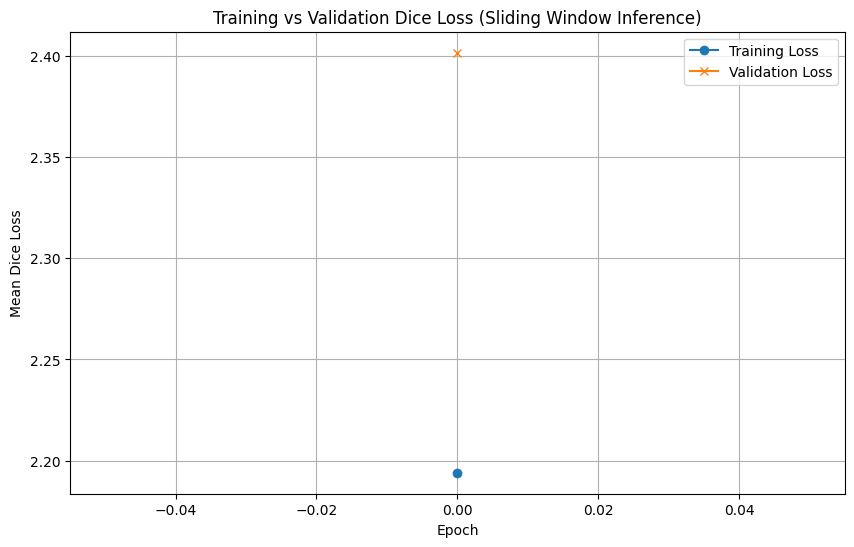

In [ ]:
#-------------------------------------------------------------
#--- PLOTTING TRAINING AND VALIDATION LOSS
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- PLOTTING TRAINING AND VALIDATION LOSS")
print("#-------------------------------------------------------------\n")

# Unzip epoch-wise loss lists
train_epochs, train_losses = zip(*training_losses)
val_epochs, val_losses = zip(*validation_losses)

# Plot losses
plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_losses, label="Training Loss", marker='o')
plt.plot(val_epochs, val_losses, label="Validation Loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Mean Dice Loss")
plt.title("Training vs Validation Dice Loss (Sliding Window Inference)")
plt.legend()
plt.grid(True)
plt.savefig("seg_net_pretrained_losses.png")
plt.show()


#-------------------------------------------------------------
#--- PLOTTING TRAINING AND VALIDATION DSC
#-------------------------------------------------------------



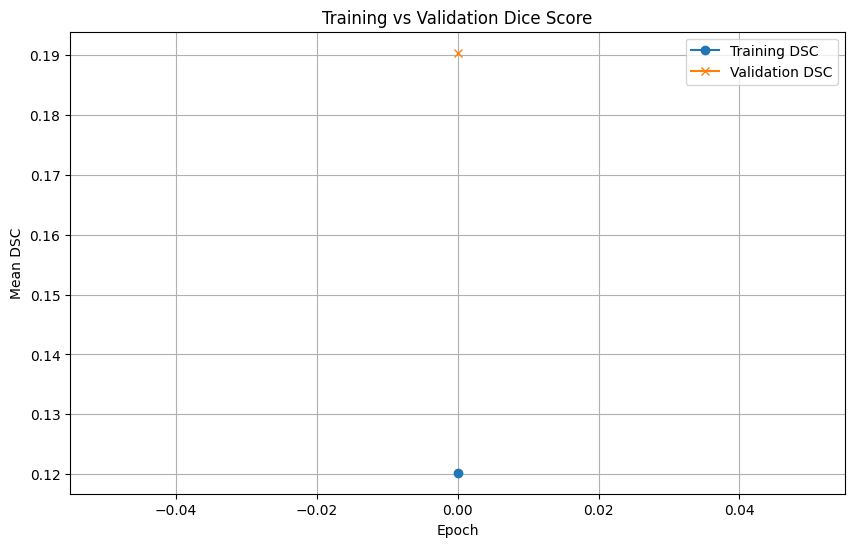

In [ ]:
#-------------------------------------------------------------
#--- PLOTTING TRAINING AND VALIDATION DSC
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- PLOTTING TRAINING AND VALIDATION DSC")
print("#-------------------------------------------------------------\n")

# Unzip epoch-wise DSC lists
train_epochs, train_dscs = zip(*training_dices)
val_epochs, val_dscs = zip(*validation_dices)

# Plot DSC
plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_dscs, label="Training DSC", marker='o')
plt.plot(val_epochs, val_dscs, label="Validation DSC", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Mean DSC")
plt.title("Training vs Validation Dice Score")
plt.legend()
plt.grid(True)
plt.savefig("seg_net_pretrained_dsc.png")
plt.show()


In [ ]:
#-------------------------------------------------------------
#--- CHECKPOINT SAVE FOR SEG NET
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- CHECKPOINT SAVE FOR SEG NET")
print("#-------------------------------------------------------------\n")

torch.save(seg_net.state_dict(), "seg_net_pretrained.pth")

#-------------------------------------------------------------
#--- CHECKPOINT SAVE FOR SEG NET
#-------------------------------------------------------------



In [ ]:
#-------------------------------------------------------------
#--- CHECKPOINT LOAD IF NECESSARY
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- CHECKPOINT LOAD IF NECESSARY")
print("#-------------------------------------------------------------\n")

# CHECKPOINT CELL; LOAD
# seg_net.load_state_dict(torch.load('seg_net_pretrained.pth', weights_only=True))

#-------------------------------------------------------------
#--- CHECKPOINT LOAD IF NECESSARY
#-------------------------------------------------------------



#-------------------------------------------------------------
#--- TRYING OUT SEGNET ON RANDOM VALIDATION
#-------------------------------------------------------------

Original image from validation set:


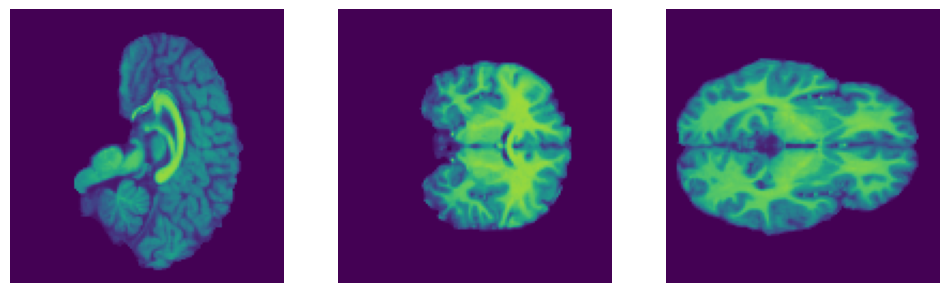

Ground truth segmentation:


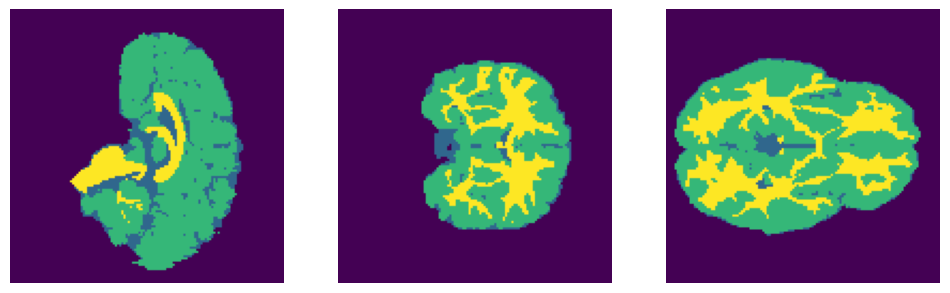

Our predicted segmentation:


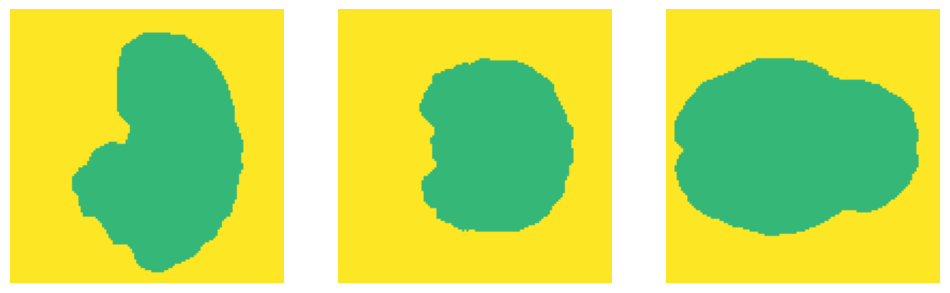

In [ ]:
#-------------------------------------------------------------
#--- TRYING OUT SEGNET ON RANDOM VALIDATION
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- TRYING OUT SEGNET ON RANDOM VALIDATION")
print("#-------------------------------------------------------------\n")

seg_net.to(device)

data_item = random.choice(dataset_seg_available_valid)
test_input = data_item["img"]
test_seg_true = data_item["seg"]
seg_net.eval()
with torch.no_grad():
    test_seg_predicted = seg_net(test_input.unsqueeze(0).cuda()).cpu()

print("Original image from validation set:")
preview_image(test_input[0])
print("Ground truth segmentation:")
preview_image(test_seg_true[0])
print("Our predicted segmentation:")
preview_image(torch.argmax(torch.softmax(test_seg_predicted, dim=1), dim=1, keepdim=True)[0, 0])

del test_seg_predicted
torch.cuda.empty_cache()